## Adaptive Linear Regression Example

The given code implements an adaptive linear regression algorithm in a graph-based computational model using the trengx package. The algorithm, expressed as a computation graph, performs sequential operations: estimating an output value, calculating the error, and updating a parameter estimate for the next step. The nodes represent computations and values while edges denote data flow. After initializing the graph and setting initial values, the current estimates and error are printed, reflecting the state of the model at a particular iteration.

i: time index

y: measured y value

y_est: estimated (predicted) y value

w: real paramter value

w_est: estimated parameter value

lr: learning rate

y[i] = w[i]*y[i-1] + random noise

y_est[i] = w_est[i]*y[i-1]

e[i] = y[i] - y_est[i]

w_est[i+1] = w_est[i] + lr*y[i-1]*e[i]



In [9]:
"""
This script prepares your Python environment by loading essential tools for handling environment variables, 
interacting with a Neo4j graph database, and utilizing a bespoke graph module, which could be sourced 
from either a local graph class or optionally from the trengx package.

import os: 
This line imports the built-in Python module os, which provides a portable way of using 
operating system dependent functionality, like reading or writing to the environment.

from dotenv import load_dotenv: 
This line imports the load_dotenv function from the dotenv module. 
This function reads a file (by default, a file named .env in the same directory as the script) and 
loads its contents as environment variables.

from neo4j import GraphDatabase as graphdb: 
This line imports the GraphDatabase class from the neo4j module, and renames it to graphdb 
in your script for convenience. This class is used to interact with a Neo4j graph database.

import sys and sys.path.append('../trengx'): 
These lines modify the system path that Python uses to look for modules. The sys module provides access 
to some variables used or maintained by the Python interpreter. In this case, it's used to add 
the parent directory's trengx subdirectory to the list of directories that Python will search when you import a module.

import graph: This line imports the graph module, which is expected to be found in the trengx directory 
that was just added to the system path. This module likely contains the Graph class that you use in your script. 
The specific functionality of this module depends on its implementation, but based on context, 
it likely provides tools for creating and manipulating a computational graph.
"""

# %pip install trengx
# from trengx import graph

import os
from dotenv import load_dotenv
from neo4j import GraphDatabase as graphdb
import sys
sys.path.append('../trengx')
import graph

In [7]:
# Retrieve secrets (confidential credentials) from environment variables stored in .env file
uri = os.getenv('NEO4J_URI') # Get the value of the uri variable
user = os.getenv('NEO4J_USER') # Get the value of the user variable
password= os.getenv('NEO4J_PASSWORD')  # Get the value of the pw variable

# Create a Graph class instance
g = graph.Graph(graphdb, uri, user, password)


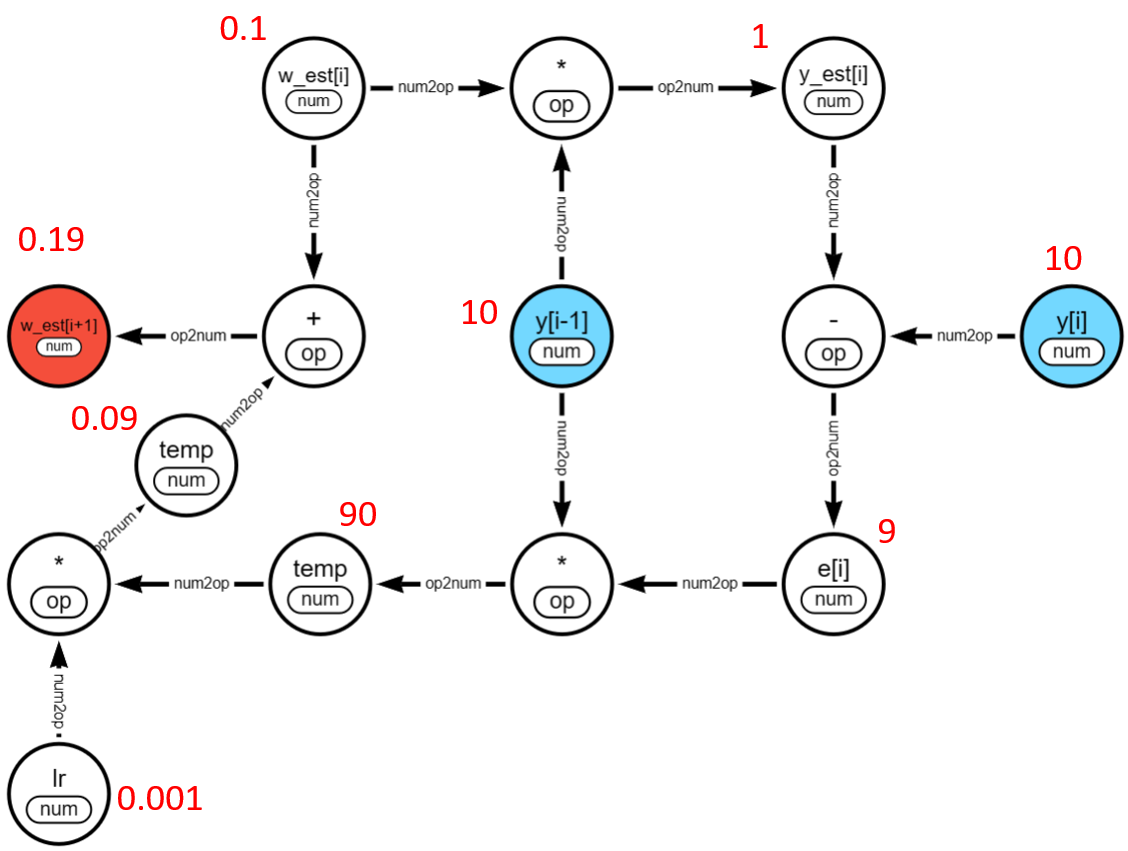

In [8]:
"""

This script builds a computation graph capable of being executed at a later time, with the execution 
triggered by an event that sets the value of y[i-1]. 

In this computation graph, nodes correspond to variables or operations, and edges indicate 
the data flow between nodes. The addition of nodes to the graph is achieved through the usage of g.add_node, 
while edges are established using g.add_edge. The 'trigger' property of edges determines their participation 
in the active main path of computations. Edges with a 'trigger' value of true are always part of the active main path, 
particularly when involving the first operand in mathematical operations. On the other hand, edges 
with a 'trigger' value of false play a passive role as they are used for the second operand. 
The value of each variable is assigned during node creation and can be subsequently accessed using 
the node's unique identifier (ID). The value of the 'reverse' property determines whether 
the mathematical operation associated with that edge should be performed in reverse order.

g.delete_all(): 
This command deletes all existing nodes and edges in the graph to ensure we're starting with a clean slate.

y_est[i] = w_est[i]*y[i-1]: 
This equation is creating a node for the estimated value of y at time i based on the estimated weight at time i 
and the actual value of y at time i-1. The code sets up nodes for w_est[i] and y[i-1], 
connects them with a multiplication operation (*), and finally stores the result in y_est[i].

e[i] = y[i] - y_est[i]: 
This equation calculates the error at time i, which is the difference between the actual and 
estimated values of y at time i. The code sets up nodes for y[i] and y_est[i], 
connects them with a subtraction operation (-), and finally stores the result in e[i].

w_est[i+1] = w_est[i] + lr*y[i-1]*e[i]: This equation updates the estimated weight at time i+1 
based on the estimated weight at time i, the learning rate lr, the actual value of y at time i-1, 
and the error at time i. The code first calculates the product of y[i-1] and e[i], 
multiplies this with lr, then adds this to w_est[i], and finally stores the result in w_est[i+1].
"""
g.delete_all()

# y_est[i] = w_est[i]*y[i-1]

""" 
w_est_i: A variable representing w_est[i]
g.add_node: This function adds a new node to the computation graph g.
'num': This specifies the type of the node, indicating that it represents a numeric variable.
'w_est_i': This is the name assigned to the node (w_est[i]), allowing it to be referenced later in the graph.
{'value': 0.1}: This is a dictionary specifying the properties of the node. In this case, it sets the initial value of the variable to 0.1.
"""
w_est_i = g.add_node ('num', 'w_est_i', {'value': 0.1})  
w_est_i_id = w_est_i['id']
y_im1 = g.add_node ('num', 'y_im1 ', {'value': 10})  # y_im1: y[i-1]
y_im1_id = y_im1['id']
mul = g.add_node ('op', '*', {'reverse':False})  # mul: multiplication
mul_id = mul['id']

"""
g.add_edge: This function adds a new edge to the computation graph g.
'num2op': This edge label indicates the relationship between the nodes. In this case, it suggests 
that the w_est_i 'number' node is connected to the multiplication operation node.
w_est_i_id: This is the ID or unique identifier of the w_est_i node, which represents the source of the edge.
mul_id: This is the ID of the mul operation node, which represents the destination of the edge.
{'trigger': False}: This is a dictionary specifying the properties of the edge. Here, the trigger property 
is set to False, indicating that this edge does not belong to the main computation path 
and is passively involved in the calculations.
"""
g.add_edge ('num2op', w_est_i_id, mul_id, {'trigger':False})
g.add_edge ('num2op', y_im1_id, mul_id, {'trigger':True})
y_est_i = g.add_node ('num', 'y_est_i', {'value': 0}) # y_est_i: y_est[i]
y_est_i_id = y_est_i['id']
g.add_edge ('op2num', mul_id, y_est_i_id, {'trigger':True})

# e[i] = y[i] - y_est[i]
y_i = g.add_node ('num', 'y_i', {'value': 10}) # y_i: y[i]
y_i_id = y_i['id']
""" 
When the 'reverse' property is set to True for a subtraction operation, 
it means that the operands involved in the operation will be reversed. 
In other words, the second operand will be subtracted from the first operand, 
rather than the usual order of subtracting the first operand from the second operand.
"""
sub = g.add_node ('op', '-', {'reverse':True})  # sub: substraction
sub_id = sub['id']
g.add_edge ('num2op', y_i_id, sub_id, {'trigger':False})
g.add_edge ('num2op', y_est_i_id, sub_id, {'trigger':True})
e_i = g.add_node ('num', 'e_i', {'value': 0.2})
e_i_id = e_i['id']
g.add_edge ('op2num', sub_id, e_i_id, {'trigger':True})

# w_est[i+1] = w_est[i] + lr*y[i-1]*e[i]
mul = g.add_node ('op', '*', {'reverse':False})
mul_id = mul['id']
g.add_edge ('num2op', y_im1_id, mul_id, {'trigger':False})
g.add_edge ('num2op', e_i_id, mul_id, {'trigger':True})
temp1 = g.add_node ('num', 'temp1', {'value': 1.0})
temp_id_1 = temp1['id']
g.add_edge ('op2num', mul_id, temp_id_1, {'trigger':True})
lr = g.add_node ('num', 'lr', {'value': 0.001})
lr_id = lr['id']
mul = g.add_node ('op', '*', {'reverse':False})
mul_id = mul['id']
g.add_edge ('num2op', temp_id_1, mul_id,{'trigger':True})
g.add_edge ('num2op', lr_id, mul_id, {'trigger':False})
temp2 = g.add_node ('num', 'temp2', {'value': 1.0})
temp_id_2 = temp2['id']
g.add_edge ('op2num', mul_id, temp_id_2, {'trigger':True})
add = g.add_node ('op', '+', {'reverse':False})
add_id = add['id']
g.add_edge ('num2op', w_est_i_id, add_id, {'trigger':False})
g.add_edge ('num2op', temp_id_2, add_id, {'trigger':True})
w_est_ip1 = g.add_node ('num', 'w_est_ip1', {'value': 0.2})
w_est_ip1_id = w_est_ip1['id']
g.add_edge ('op2num', add_id, w_est_ip1_id, {'trigger':True})


[{'edge_id': 11,
  'edge_label': 'op2num',
  'out_node_id': 479,
  'in_node_id': 480,
  'properties': {'trigger': True}}]

In [5]:
"""
g.set_node_value: This function is responsible for updating the value of a node in the computation graph g.
y_im1_id: This is the ID or unique identifier of the node that you want to update.
10: This is the new value that you are assigning to the specified node.
"""
g.set_node_value(y_im1_id, 10)

""" 
g.get_node_prop: This function is used to retrieve the value of a specific property from a node in the computation graph g.
y_est_i_id: This is the ID or unique identifier of the node from which you want to retrieve the property value.
'value': This is the name of the property that you are interested in.
"""
print (g.get_node_prop(y_est_i_id, 'value'))
print (g.get_node_prop(e_i_id, 'value'))
print (g.get_node_prop(temp_id_1, 'value'))
print (g.get_node_prop(temp_id_2, 'value'))
print (g.get_node_prop(w_est_ip1_id, 'value'))

1.0
9.0
90.0
0.09
0.19
